In [48]:
#Feature Extraction and Embedding for Learning Similarity
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.cluster import OPTICS
import itertools
import time
import warnings
from sklearn.exceptions import ConvergenceWarning

In [49]:
CLUSTERING_ALGO = "simplified_kmeans"
ACTIVATION_THRESHOLD = 200  #put 235
SIMPLE_KMEANS_PIVOT = 200 #put 225
VALID_SAME = "VALID" #put VALID
def create_filter_for_tf(np_arr):
  np_arr=np_arr.reshape(np_arr.shape[0],np_arr.shape[1],1,1)
  return np_arr

def create_image_for_tf(np_arr):
  if np_arr.ndim == 2:
    # Add a third dimension with size 1
    np_arr = np.expand_dims(np_arr, axis=-1)
  np_array = np_arr.reshape(1,np_arr.shape[0],np_arr.shape[1],np_arr.shape[2])
  return tf.convert_to_tensor(np_array, dtype=tf.float32)

def display_str(image):
  output = cv2.imread(image)
  plt.imshow(output,cmap='gray')
  plt.show()

def display(image):
  plt.imshow(image,cmap='gray')
  plt.show()

def tensor_contains_float(tensor):
    # Convert tensor elements to int and subtract from original
    diff = tensor - tf.math.floor(tensor)

    # Check if there is any element whose difference is greater than 0.0001
    if tf.reduce_any(tf.math.abs(diff) > 0.0001):
        return True
    else:
        return False

"""
When displaying an image using plt.imshow() with the cmap='gray' option,
the pixel values are mapped to a grayscale color map. By default,
 the lowest pixel value in the image is mapped to black, and the
 highest pixel value is mapped to white. Any intermediate pixel values are linearly
 interpolated to a corresponding shade of gray between black and white.
"""

# Grayscale Image
def processImage(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    return image

def convert_to_0255(image,lower_bound,upper_bound):
  if(upper_bound==lower_bound):
    upper_bound=255
    lower_bound=0
  new_image=((image-lower_bound)*255)/(upper_bound-lower_bound)
  return new_image

class GreyScaler:
    def __init__(self, image):
      #image : tensor of shape (h,W)
      self.lower_bound = tf.math.reduce_min(image)
      self.upper_bound = tf.math.reduce_max(image)
      if tf.math.is_inf(self.lower_bound):
        print("Warning: lower_bound is infinity.")
      if tf.math.is_inf(-self.lower_bound):
        print("Warning: lower_bound is negative infinity.")
      if tf.math.is_inf(self.upper_bound):
        print("Warning: upper_bound is infinity.")
      if tf.math.is_inf(-self.upper_bound):
        print("Warning: upper_bound is negative infinity.")
    def fit(self, input_data):
     # print(" we fit an input data ")
      #print(" lower bound : "+str(self.lower_bound))
      #print(" upper bound : "+str(self.upper_bound))
      if(self.lower_bound<0 or self.upper_bound>256):
        scaled_data = convert_to_0255(input_data, self.lower_bound, self.upper_bound)
        return scaled_data
      else:
        return input_data

class Filter2D:
    def __init__(self,x_arr,y_arr):
      # shape of x_arr : (3,3,1,num_of_1Dfilers)
      #y_arr is the list of filters that are applied on the corresponding 1D filter , shape of y_arr : (3,3,num_of_1Dfilers,1)
      assert(y_arr.shape[2]==x_arr.shape[3])
      self.Xs = x_arr
      self.Ys = y_arr

def standardize(img):
  img = (img-np.mean(img))/np.std(img)
  return img

In [50]:
def test_convert_to_0255_single_image(image_tensor):
    res = convert_to_0255(image_tensor,tf.math.reduce_min(image_tensor),tf.math.reduce_max(image_tensor))
    assert(tf.math.reduce_max(res) <256)
    assert(tf.math.reduce_min(res) >-1)
def test_convert_to_0255():
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=-300, maxval=0)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=-340, maxval=10)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=0, maxval=70)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=70, maxval=199)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=45, maxval=255)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=-300, maxval=360)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=0, maxval=255)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=255, maxval=678)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=300, maxval=6789)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=-30000000, maxval=400000)
  test_convert_to_0255_single_image(random_tensor)
  random_tensor = tf.random.uniform(shape=(1, 10, 13, 3), minval=1234567894, maxval=123455555667899)
  test_convert_to_0255_single_image(random_tensor)

In [51]:
test_convert_to_0255()

In [52]:
### TRYING TO SOLVE F in the equation : F * G = H
"""
def inverse_cross_correlation(H, G):
    # Reverse G along spatial dimensions (assuming 2D matrices)
    G_reversed = tf.reverse(G, axis=[0, 1])

    # Perform cross-correlation between H and reversed G
    F = tf.nn.conv2d(H[tf.newaxis, ..., tf.newaxis], G_reversed[tf.newaxis, ..., tf.newaxis], strides=[1, 1, 1, 1], padding=VALID_SAME)
    return F[0, ..., 0]

# Example usage:
G = tf.constant([[[[1]],[[2]]],[[[3]],[[4]]]], dtype=tf.float32)
H = tf.constant([[10, 19, 22], [37, 54, 41], [51, 68, 46]], dtype=tf.float32)

F = inverse_cross_correlation(H, G)
print(F.numpy())
"""

'\ndef inverse_cross_correlation(H, G):\n    # Reverse G along spatial dimensions (assuming 2D matrices)\n    G_reversed = tf.reverse(G, axis=[0, 1])\n\n    # Perform cross-correlation between H and reversed G\n    F = tf.nn.conv2d(H[tf.newaxis, ..., tf.newaxis], G_reversed[tf.newaxis, ..., tf.newaxis], strides=[1, 1, 1, 1], padding=VALID_SAME)\n    return F[0, ..., 0]\n\n# Example usage:\nG = tf.constant([[[[1]],[[2]]],[[[3]],[[4]]]], dtype=tf.float32)\nH = tf.constant([[10, 19, 22], [37, 54, 41], [51, 68, 46]], dtype=tf.float32)\n\nF = inverse_cross_correlation(H, G)\nprint(F.numpy())\n'

In [53]:
def get_clusters(numpy_array,algorithm=CLUSTERING_ALGO,min_size_cluster=2,epsilon=0.2,pivot=SIMPLE_KMEANS_PIVOT):
  #numpy array is 1D array
  if(algorithm=="simplified_dbscan"):
    return simplified_dbscan(numpy_array,min_size_cluster,epsilon)
  elif(algorithm=="simplified_kmeans"):
    pivot = 0.75 * np.max(numpy_array)
    res = simplified_kmeans(numpy_array,pivot)
    return res
  elif(algorithm=="kmeans"):
    numpy_array=np.array(numpy_array)
    numpy_array=np.sort(numpy_array)
    init_points = np.array([[10], [128], [250]])
    assert(np.isnan(numpy_array).any() ==False)

    #warnings.filterwarnings("ignore", category=ConvergenceWarning)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        clustering=None
        try:
          clustering = KMeans(n_clusters=3,init=init_points,n_init=1).fit(numpy_array.reshape(-1,1))
        except ConvergenceWarning:
            print('Warning: Convergence issue occurred. Adjusting number of clusters...')
            clustering = KMeans(n_clusters=2,init=np.array([[69], [250]]) ,n_init=1).fit(numpy_array.reshape(-1,1))
            #clustering = KMeans(n_clusters=1,init=np.array([[160]]) ,n_init=1).fit(numpy_array.reshape(-1,1))

        centroids = clustering.cluster_centers_
        labels = clustering.labels_
        unique_clusters = set(clustering.labels_)
        #the code below can by simplified if we sort the numpy_array before clustering
        # Find starting and ending points for each cluster
        res=[]
        #if len(unique_clusters) < 3:
          #return res
        for i in range(clustering.n_clusters):
          # Get the indices of data points assigned to the current cluster
          indices = np.where(labels == i)[0]
          if(indices.size>0):
            # Get the first and last value for the current cluster
            start = numpy_array[indices.min()]
            end = numpy_array[indices.max()]
            # Get the centroid for the current cluster
            mean = centroids[i][0]
            size = len(indices)
            res.append([start,end,mean,size])
        return res
  elif(algorithm=="optics"):
    numpy_array=np.array(numpy_array)
    clustering = OPTICS(min_samples=min_size_cluster).fit(numpy_array.reshape(-1,1))
    # Get unique cluster labels, excluding noise (-1)
    print(clustering.labels_)
    unique_clusters = set(clustering.labels_)
    unique_clusters.discard(-1)
    #the code below can by simplified if we sort the numpy_array before clustering
    # Find starting and ending points for each cluster
    res=[]
    for cluster_label in unique_clusters:
        cluster_indices = np.where(clustering.labels_ == cluster_label)[0]
        start_index = cluster_indices.min()
        end_index = cluster_indices.max()
        cluster_elements = numpy_array[cluster_indices]
        start = numpy_array[start_index]
        end = numpy_array[end_index]
        mean = np.mean(cluster_elements)
        size = len(cluster_elements)
        res.append([start,end,mean,size])
    return res

In [54]:


def simplified_dbscan(numpy_array,min_size_cluster,epsilon):
  #do a clustering similar to dbscan and
  #return two arrays where arr1[i] and arr2[i] are the min and max value of cluster i
  #OLD : return the distance between the last cluster and the before last cluster : min element of last - maxelement of beforelast
  #we can improve this algirhtm by not letting epsilon eat values far away from the min (or max) so that the cluster have a maximum standard deviation
  numpy_array=np.sort(numpy_array)
  clusters=[] #1st column : start, 2nd col : end, 3rd col :mean, 4th col : size
  total_sum=numpy_array[0]
  last_cluster_end = 0
  last_cluster_start = 0
  cluster_size = 1
  previous_cluster_start=-1
  numpy_array=np.append(numpy_array,numpy_array[-1]+3*epsilon)
  for i in range(1,len(numpy_array)):
    if(numpy_array[i]-numpy_array[last_cluster_end]<=epsilon): #we keep eating
      cluster_size+=1
      total_sum+=numpy_array[i]
    elif(cluster_size>=min_size_cluster): #after eating, we append this cluster
      last_element = numpy_array[last_cluster_end]
      previous_cluster_start=last_cluster_start
      first_element = numpy_array[previous_cluster_start]
      mean = total_sum/cluster_size
      size = cluster_size
      clusters.append([first_element,last_element,mean,size])
      last_cluster_start=i
      cluster_size=1
      total_sum=numpy_array[i]
    else: #after eating, we dismiss this cluster
      last_cluster_start=i
      cluster_size=1
      total_sum=numpy_array[i]
    last_cluster_end=i
  return clusters
  #return (numpy_array[last_cluster_start]-numpy_array[last_elements[-1]])#/(np.max(numpy_array)-np.min(numpy_array))


In [55]:

#print(get_clusters([1, 2, 2, 3, 10, 25, 26, 27], algorithm='kmeans', min_size_cluster=3, epsilon=2))
#print(get_clusters([1, 2, 2, 3, 10, 25, 26, 27,56,57,57,58,59,58, 123,124,126,124,2345,256789], algorithm='kmeans', min_size_cluster=5, epsilon=2))

In [56]:
def test_get_clusters(input,algorithm=CLUSTERING_ALGO,cluster_size=3,epsilon=0.3,arr1=[],arr2=[],mean_t=[],pivot=SIMPLE_KMEANS_PIVOT):
  clusters = get_clusters(input,algorithm,cluster_size,epsilon,pivot)
  if(clusters is not None):
    start = [cluster[0] for cluster in clusters]
    end = [cluster[1] for cluster in clusters]
    means = [cluster[2] for cluster in clusters]
    sizes = [cluster[3] for cluster in clusters]
    assert(start==arr1)
    assert(end==arr2)
    assert(np.allclose(means, mean_t, rtol=0, atol=1e-1))
  else:
    assert(arr1 is None)
    assert(arr2 is None)
    assert(mean_t is None)



In [57]:
#UNIT TESTS : ONLY FOR SIMPLIFIED DBSCAN
#assert(get_last_clusters_dist(np.array([1,2,2,3,8,9,9,15,16,17]),3,2)==6)
"""
test_get_clusters(np.array([1,2,2,3,8,9,9,15,16,17]),3,2,[1,8,15],[3,9,17],[2,8.67,16])
test_get_clusters(np.array([1,2,2,3,10,25,26,27]),3,2,[1,25],[3,27],[2,26])
test_get_clusters(np.array([1,1,1,1,2,2]),3,2,[1],[2],[1.333])
test_get_clusters(np.array([2,8,9,9,25]),3,2,[8],[9],[8.666])
test_get_clusters(np.array([1,2,3,4,18,26,27,28,43,60,61,62]),3,2,[1,26,60],[4,28,62],[2.5,27,61])
test_get_clusters(np.array([1,2,2,4,4,4,4,10,11,12,12,14,15]),3,3,[1,10],[4,15],[3,12.33])
test_get_clusters(np.array([14,28,42,64]),3,3,[],[],[])
test_get_clusters(np.array([1,2,2,3,4,10,11,12,25,26,27,28]),4,2,[1,25],[4,28],[2.4,26.5])
test_get_clusters(np.array([1,2,2,3,8,9,9,15,16,17]),1,2,[1,8,15],[3,9,17],[2,8.67,16])
test_get_clusters(np.array([1,2,2,3,10,25,26,27]),1,2,[1,10,25],[3,10,27],[2,10,26])
test_get_clusters(np.array([1,1,1,1,2,2]),1,2,[1],[2],[1.333])
test_get_clusters(np.array([10,11,12,13,13,14,18,19,20,25,31,32,32,32,33,34]),5,1,[10,31],[14,34])
test_get_clusters(np.array([2,3,3,4,12,13,14,15,21,30,31,32,33,45]),3,2,[2,12,30],[4,15,33])
test_get_clusters(np.array([2,8,9,9,25]),1,2,[2,8,25],[2,9,25])
test_get_clusters(np.array([1,2,3,4,18,26,27,28,43,60,61,62]),3,50,[1],[62])
test_get_clusters(np.array([1,2,2,4,4,4,4,10,11,12,12,14,15]),3,1,[1,4,10],[2,4,12])
test_get_clusters(np.array([2,6,31,32,34,38]),3,5,[31],[38])
test_get_clusters(np.array([2,6,31,32,34,38,46,48,49,50,74,74,74]),3,5,[31,46,74],[38,50,74])
test_get_clusters(np.array([14,28,42,64]),1,3,[14,28,42,64],[14,28,42,64])
test_get_clusters(np.array([1,2,2,3,4,10,11,12,25,26,27,28]),7,2,[],[])
test_get_clusters(np.array([1,2,2,3,8,9,9,11,13,15,16,17]),1,2,[1,8],[3,17])
test_get_clusters(np.array([5,10,21,22,23,43,43,44]),3,4,[21,43],[23,44])
test_get_clusters(np.array([2,2,3,10,11,21,22,23,24,43,43,44,44]),4,4,[21,43],[24,44])
test_get_clusters(np.array([5,8,9,10,25,54]),3,5,[5],[10])
test_get_clusters(np.array([-10,-2,5,8,9,10,25,54]),3,5,[5],[10])
test_get_clusters(np.array([-10,-9,-8,-7,5,8,9,10,25,54]),3,5,[-10,5],[-7,10])
test_get_clusters(np.array([-100,-99,-54,-53,-10,-9,-8,-7,5,8,9,10,25,54]),3,5,[-10,5],[-7,10])
test_get_clusters(np.array([-9.3,-9.3,-9.1,-9.1,-6.5,-6.4,-6.3,-1,-0.9,-0.9,-0.8,0,2,2.2]),3,0.21,[-9.3,-6.5,-1],[-9.1,-6.3,-0.8])
print("ALL TESTS PASSED !")
"""


'\ntest_get_clusters(np.array([1,2,2,3,8,9,9,15,16,17]),3,2,[1,8,15],[3,9,17],[2,8.67,16])\ntest_get_clusters(np.array([1,2,2,3,10,25,26,27]),3,2,[1,25],[3,27],[2,26])\ntest_get_clusters(np.array([1,1,1,1,2,2]),3,2,[1],[2],[1.333])\ntest_get_clusters(np.array([2,8,9,9,25]),3,2,[8],[9],[8.666])\ntest_get_clusters(np.array([1,2,3,4,18,26,27,28,43,60,61,62]),3,2,[1,26,60],[4,28,62],[2.5,27,61])\ntest_get_clusters(np.array([1,2,2,4,4,4,4,10,11,12,12,14,15]),3,3,[1,10],[4,15],[3,12.33])\ntest_get_clusters(np.array([14,28,42,64]),3,3,[],[],[])\ntest_get_clusters(np.array([1,2,2,3,4,10,11,12,25,26,27,28]),4,2,[1,25],[4,28],[2.4,26.5])\ntest_get_clusters(np.array([1,2,2,3,8,9,9,15,16,17]),1,2,[1,8,15],[3,9,17],[2,8.67,16])\ntest_get_clusters(np.array([1,2,2,3,10,25,26,27]),1,2,[1,10,25],[3,10,27],[2,10,26])\ntest_get_clusters(np.array([1,1,1,1,2,2]),1,2,[1],[2],[1.333])\ntest_get_clusters(np.array([10,11,12,13,13,14,18,19,20,25,31,32,32,32,33,34]),5,1,[10,31],[14,34])\ntest_get_clusters(np.arr

In [58]:
def simplified_kmeans2222(numpy_array,pivot):

  if(len(numpy_array)==0):
    return None
  left_mean=0
  left_size=0
  right_mean=0
  right_size=0
  left_min=9999999
  right_min=9999999
  left_max=-999999
  right_max=-9999999
  for elem in numpy_array:
    if(elem<pivot):
      left_mean+=elem
      left_size+=1
      left_min=min(left_min,elem)
      left_max=max(left_max,elem)
    else:
      right_mean+=elem
      right_size+=1
      right_min=min(right_min,elem)
      right_max=max(right_max,elem)


  if(left_size>0):
    left_mean=left_mean/left_size
  else:

    return None

  if(right_size>0):
    right_mean=right_mean/right_size
  else:
    return None

  res=[]
  res.append([left_min,left_max,left_mean,left_size])
  res.append([right_min,right_max,right_mean,right_size])
  return res

def simplified_kmeans(numpy_array, pivot):

    if len(numpy_array) == 0:
        return None

    numpy_array = np.array(numpy_array)  # Convert to NumPy array for vectorized operations
    left_indices = numpy_array < pivot
    right_indices = numpy_array >= pivot

    # If there are no elements on either side of the pivot, return None
    if not np.any(left_indices) or not np.any(right_indices):
        return None

    left_values = numpy_array[left_indices]
    right_values = numpy_array[right_indices]

    left_stats = [np.min(left_values), np.max(left_values), np.mean(left_values), len(left_values)]
    right_stats = [np.min(right_values), np.max(right_values), np.mean(right_values), len(right_values)]

    res = [left_stats, right_stats]
    return res

In [59]:
"""
def test_simplified_kmeans():
  test_get_clusters(np.array([142,238,80,328,180,78,202]),algorithm="simplified_kmeans",arr1=[78,202],arr2=[180,328],mean_t=[120,256],pivot=200)
  test_get_clusters(np.array([14,8,2,1,1,14]),algorithm="simplified_kmeans",arr1=[1,14],arr2=[8,14],mean_t=[3,14],pivot=13)
  test_get_clusters(np.array([25,1,13,12]),algorithm="simplified_kmeans",arr1=[1,25],arr2=[13,25],mean_t=[8.667,25],pivot=20)
  test_get_clusters(np.array([20,12,22,45]),algorithm="simplified_kmeans",arr1=[12,20],arr2=[12,45],mean_t=[12,29],pivot=15)
  test_get_clusters(np.array([8,11]),algorithm="simplified_kmeans",arr1=[8,11],arr2=[8,11],mean_t=[8,11],pivot=10)
  test_get_clusters(np.array([17,16,300]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot=14)
  test_get_clusters(np.array([1,2,3]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot=12)
  test_get_clusters(np.array([]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot=18)
  test_get_clusters(np.array([6,1,5,3,20,7]),algorithm="simplified_kmeans",arr1=[1,6],arr2=[5,20],mean_t=[3,11],pivot=6)
  test_get_clusters(np.array([6,1,5,3,20,7,6]),algorithm="simplified_kmeans",arr1=[1,6],arr2=[5,20],mean_t=[3,9.75],pivot=6)
  """

'\ndef test_simplified_kmeans():\n  test_get_clusters(np.array([142,238,80,328,180,78,202]),algorithm="simplified_kmeans",arr1=[78,202],arr2=[180,328],mean_t=[120,256],pivot=200)\n  test_get_clusters(np.array([14,8,2,1,1,14]),algorithm="simplified_kmeans",arr1=[1,14],arr2=[8,14],mean_t=[3,14],pivot=13)\n  test_get_clusters(np.array([25,1,13,12]),algorithm="simplified_kmeans",arr1=[1,25],arr2=[13,25],mean_t=[8.667,25],pivot=20)\n  test_get_clusters(np.array([20,12,22,45]),algorithm="simplified_kmeans",arr1=[12,20],arr2=[12,45],mean_t=[12,29],pivot=15)\n  test_get_clusters(np.array([8,11]),algorithm="simplified_kmeans",arr1=[8,11],arr2=[8,11],mean_t=[8,11],pivot=10)\n  test_get_clusters(np.array([17,16,300]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot=14)\n  test_get_clusters(np.array([1,2,3]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot=12)\n  test_get_clusters(np.array([]),algorithm="simplified_kmeans",arr1=None,arr2=None,mean_t=None,pivot

In [60]:
#test_simplified_kmeans()

In [61]:
def analyze_filter(filter,image1,image2,dim=-1):
  assert(dim>0)
  #filter shape should be (3,3,k,1)
  assert(filter.shape[0]==3 and filter.shape[1]==3)
  image1 = np.array(image1, dtype=np.float32)
  image2 = np.array(image2, dtype=np.float32)
  out1 = tf.nn.conv2d(image1.reshape(1, image1.shape[0], image1.shape[1], 1), filter,strides=(1,1), padding=VALID_SAME)
  out2 = tf.nn.conv2d(image2.reshape(1, image2.shape[0], image2.shape[1], 1), filter,strides=(1,1), padding=VALID_SAME)

  out1 = out1.numpy()
  out2 = out2.numpy()

  print("shape of image1 and image2 = ")
  print(image1.shape)
  print(image2.shape)
  print("       FILTER :    ")
  print(filter)
  score_result,clust1,clust2,_,_=score4(filter,create_image_for_tf(image1),create_image_for_tf(image2),dim=dim,debug=True)
  print("score = "+str(score_result))

  #reshape before calling display
  out1 = out1.reshape(out1.shape[1], out1.shape[2])
  out2 = out2.reshape(out2.shape[1], out2.shape[2])

  out1 = ((out1 - np.min(out1)) / (np.max(out1) - np.min(out1))) * 255
  out2 = ((out2 - np.min(out2)) / (np.max(out2) - np.min(out2))) * 255

  # convert to RGB
  out1_color = np.dstack([out1, out1, out1])
  out2_color = np.dstack([out2, out2, out2])

  # colorize pixels above 200
  mask1 = out1 > 200
  mask2 = out2 > 200
  out1_color[mask1] = [255, 0, 0]
  out2_color[mask2] = [255, 0, 0]


  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))

  ax1.imshow(out1_color)
  ax1.set_title("image1")

  ax2.imshow(out2_color)
  ax2.set_title("image2")



  #ax1_hist=ax1.twinx()
 # ax2_hist=ax2.twinx()
  print(type(out1))
  print(type(out2))
  #n1, bins1, patches1 = ax3.hist(out1.numpy().flatten(), bins=20, alpha=0.5, color='red')
  #ax3.set_ylim([0, 5000])
  n1, bins1, patches1 = ax3.hist(out1.flatten(), bins=20, alpha=0.5, color='red')
  ax3.set_ylim([0, 5000])
  ax4.hist(out2.flatten(), bins=20, alpha=0.5, color='red')
  #ax4.hist(out2.numpy().flatten(), bins=20, alpha=0.5, color='red')
  ax4.set_ylim([0, 5000])

  for i in range(0,len(clust1)):
    start, end = clust1[i][0],clust1[i][1]
    color='darkturquoise'
    if(i%2==0):
      color='skyblue'
    ax3.axvspan(start, end, alpha=0.3, color=color)

  for i in range(0,len(clust2)):
    start, end = clust2[i][0],clust2[i][1]
    color='darkturquoise'
    if(i%2==0):
      color='skyblue'
    ax4.axvspan(start, end, alpha=0.3, color=color)

  # Show the plot
  plt.show()


In [62]:
def analyze_filters(filters,image1,image2):
  for filter in filters:
    analyze_filter(create_filter_for_tf(np.array(filter)),image1,image2)

In [64]:
def max_when_rare(percentage,dim=-1):
  #percentage is < 1
  #return 1/(1+np.exp(25*percentage-5))
  assert(dim>0)
  if percentage>0.001 and percentage < (1/dim): #(1/(1.8*percentage-0.8)):  #0.3:
    return 1
  return 0

def score_of_filter_on_1image(original_image,convolved_image,clustering_algorithm=CLUSTERING_ALGO,dim=-1,debug=False):
  #shape of convolved_image : (1,h,W,1)
  #shape of original_image : (1,h,W,k)
  #values of original_image are between 0 and 255
  assert(dim>0)
  assert(convolved_image.shape[-1]==1)
  convolved_image = tf.reshape(convolved_image,[convolved_image.shape[1],convolved_image.shape[2]])
  #shape of convolved_image : (h,W)

  #out1_scaler = GreyScaler(convolved_image)
  #convolved_image_scaled = out1_scaler.fit(convolved_image)
  size_out1 = convolved_image.shape[0]*convolved_image.shape[1]

  clusters_out1 = get_clusters(convolved_image.numpy().ravel(),algorithm=clustering_algorithm,min_size_cluster=5,epsilon=4.3,pivot=original_image.shape[3]*220)

  if(clusters_out1 is None):
    return 0,None

  percentage_clust_1 = 0
  mean_cluster1 = 0
  score = 0
  distance_last_two_clust1 = 0
  clusters_out1 = sorted(clusters_out1, key=lambda x: x[2])

  if(len(clusters_out1) <=1 ):
    raise Exception("  len(clusters_out1) <= 1 ")
    score=0
  elif(len(clusters_out1[0]) <=2 ):
    raise Exception("  len(clusters_out1[0]) <= 2 ")
    score=0
  else:
    #assert(tf.math.reduce_max(convolved_image)<256)
    percentage_clust_1 = clusters_out1[-1][3]/size_out1
    mean_cluster1 = clusters_out1[-1][2]
    distance_last_two_clust1 = clusters_out1[-1][2] - clusters_out1[-2][2] #1st col start, 2nd col : end, 3rd col :mean, 4th col : size

    score = mean_cluster1*max_when_rare(percentage_clust_1,dim) + 0.2*distance_last_two_clust1 #maybe for deep filters distance_last_two_clust1 should be more omportant !?
    if np.isnan(score):
      print("size_out1 "+str(size_out1))
      print(convolved_image)
      print("scaled : ")
      print(convolved_image)
      print("score = "+str(mean_cluster1)+" * max_when_rare("+str(percentage_clust_1)+") + 0.2 * "+str(distance_last_two_clust1))
      raise Exception("  Nan  ")
    elif np.isinf(score):
      print(" max element of convolved convolved_image_scaled ")
      print(tf.math.reduce_max(convolved_image))
      print("size_out1 "+str(size_out1))
      print(convolved_image)
      print("scaled : ")
      print(convolved_image)
      print("score = "+str(mean_cluster1)+" * max_when_rare("+str(percentage_clust_1)+") + 0.2 * "+str(distance_last_two_clust1))
      raise Exception("  inf  ")

  if(debug):
    print("                SCORE on this single image= "+str(score))
    print("   mean of last cluster = "+str(mean_cluster1))
    print("   percentage_clust_1 = "+str(percentage_clust_1))
    print("   distance last two clust : "+str(distance_last_two_clust1))
    print("    so score = "+str(mean_cluster1)+" * "+str(max_when_rare(percentage_clust_1))+" + " +str(0.2*distance_last_two_clust1))
    print("     => "+str(score))
    print(" ")
  return score,clusters_out1

In [65]:

def score3(filter,scaled_img1,scaled_img2,beta=0.015,debug=False):
  #out1 = convolve2D(scaled_img1, filter, padding=2)
  #out2 = convolve2D(scaled_img2, filter, padding=2)
  #filter shape should be (3,3,k,1)
  assert(filter.shape[0]==3 and filter.shape[1]==3)
  out1 = tf.nn.conv2d(scaled_img1.reshape(1, scaled_img1.shape[0], scaled_img1.shape[1], 1), filter, strides=(1,1),padding=VALID_SAME)
  out2 = tf.nn.conv2d(scaled_img2.reshape(1, scaled_img2.shape[0], scaled_img2.shape[1], 1), filter,strides=(1,1), padding=VALID_SAME)

  #shape of out1 : (1,h,W,1)

  out1 = convert_to_0255(tf.reshape(out1,[out1.shape[1],out1.shape[2]]),tf.math.reduce_min(out1),tf.math.reduce_max(out1))
  out2 = convert_to_0255(tf.reshape(out2, [out2.shape[1],out2.shape[2]]),tf.math.reduce_min(out2),tf.math.reduce_max(out2))

  print("max of out1 : "+str(np.max(out1)))
  clusters_begin_out1,clusters_end_out1 = get_clusters(out1.numpy().ravel(),50,1.2)
  clusters_begin_out2,clusters_end_out2 = get_clusters(out2.numpy().ravel(),50,1.2)

  if(min(len(clusters_begin_out1),len(clusters_end_out1)) <=1 ):
    a=0
  else:
    a=clusters_begin_out1[-1]-clusters_end_out1[-2]

  if(min(len(clusters_begin_out2),len(clusters_end_out2))<=1 ):
    b=0
  else:
    b=clusters_begin_out2[-1]-clusters_end_out2[-2]

 # a =  #+0.2*np.exp(-(4.5*(last_cluster_size/(out1.shape[1]*out1.shape[2]))-0.6)**2)
  #b = get_clusters(out2.numpy().ravel(),40,3) #+

  #a=tf.convert_to_tensor(a, dtype=tf.float32)
  #b=tf.convert_to_tensor(b, dtype=tf.float32)
  if(debug):
    print("   debug------------------------------------------")
    print("   ****IMAGE 1 ******")
    print("   a = "+str(a))

    print("   ****IMAGE 2 ******")
    print("   b = "+str(b))

  return -(a+b-beta*pow(a-b,2))

def score4(filter,tensor_img1,tensor_img2,clustering_algorithm=CLUSTERING_ALGO,dim=-1,debug=False):
  #filter shape should be (3,3,k,1)
  assert(dim>0)
  assert(filter.shape[0]==3 and filter.shape[1]==3)
  assert(tensor_img1.shape[3]==tensor_img2.shape[3])
  #shape of tensor_img1 : (1,h,W,k) k is the nbr of channels

  assert len(tensor_img1.shape) == 4, f"Expected tensor_img1 to have 4 dimensions, but got {len(tensor_img1.shape)}"
  assert len(tensor_img2.shape) == 4, f"Expected tensor_img2 to have 4 dimensions, but got {len(tensor_img2.shape)}"

  # Check that the filter has the correct number of input channels
  assert filter.shape[2] == tensor_img1.shape[3], f"Expected filter to have {tensor_img1.shape[3]} input channels, but got {filter.shape[2]}"

  assert filter.shape[2] == tensor_img2.shape[3], f"Expected filter to have {tensor_img2.shape[3]} input channels, but got {filter.shape[2]}"

  k_image = max(1,0.5*tensor_img1.shape[3]) #(1,h,w,k_image)

  a=0
  b=0
  clusters_out1 = None
  clusters_out2 = None

  #values of tensor_img1 are between 0 and 255

  assert(tf.math.reduce_max(tensor_img1)<=256 and tf.math.reduce_min(tensor_img1)>=-1,f"max = {tf.math.reduce_max(tensor_img1)}" )

  out1 = tf.nn.conv2d(tensor_img1, filter, strides=(1,1),padding=VALID_SAME)
  out2 = tf.nn.conv2d(tensor_img2, filter, strides=(1,1), padding=VALID_SAME)

  if(tf.math.reduce_max(out1)>ACTIVATION_THRESHOLD*k_image and tf.math.reduce_max(out2)>ACTIVATION_THRESHOLD*k_image):
    a,clusters_out1 = score_of_filter_on_1image(tensor_img1,out1,clustering_algorithm,dim,debug)
    b,clusters_out2 = score_of_filter_on_1image(tensor_img2,out2,clustering_algorithm,dim,debug)

  #score = -(a+b-beta*pow(a-b,2))
  score = 0
  if a>ACTIVATION_THRESHOLD and b>ACTIVATION_THRESHOLD : #put 208
    score = -(a+b)
    #print(" SCORE : = -("+str(a)+" + "+ str(b)+") = "+str(score))

  if(debug):
    print(" SCORE : = -("+str(a)+" + "+ str(b)+") = "+str(score))
  return score, clusters_out1, clusters_out2, out1, out2

<>:67: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:67: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-65-aa89a7711e5d>:67: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(tf.math.reduce_max(tensor_img1)<=256 and tf.math.reduce_min(tensor_img1)>=-1,f"max = {tf.math.reduce_max(tensor_img1)}" )


In [68]:
def is_similar_image(img_a,img_b,dim=-1):
  #shape of img_a : (1, h, W, 1)
  assert(img_a.shape[-1]==img_b.shape[-1])
  assert(dim>=0)
  filter1 = tf.random.uniform([3, 3, img_a.shape[-1], 1], minval=-50, maxval=50)
  filter2 = tf.random.uniform([3, 3, img_a.shape[-1], 1], minval=-50, maxval=50)
  filter3 = tf.random.uniform([3, 3, img_a.shape[-1], 1], minval=-50, maxval=50)

  conv_img_1a = tf.nn.conv2d(img_a, filter1, strides=(1,1),padding=VALID_SAME)
  conv_img_1b = tf.nn.conv2d(img_b, filter1, strides=(1,1),padding=VALID_SAME)
  conv_img_2a = tf.nn.conv2d(img_a, filter2, strides=(1,1),padding=VALID_SAME)
  conv_img_2b = tf.nn.conv2d(img_b, filter2, strides=(1,1),padding=VALID_SAME)
  conv_img_3a = tf.nn.conv2d(img_a, filter3, strides=(1,1),padding=VALID_SAME)
  conv_img_3b = tf.nn.conv2d(img_b, filter3, strides=(1,1),padding=VALID_SAME)

  score1a,_ = score_of_filter_on_1image(img_a,conv_img_1a,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)
  score1b,_ = score_of_filter_on_1image(img_b,conv_img_1b,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)
  score2a,_ = score_of_filter_on_1image(img_a,conv_img_2a,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)
  score2b,_ = score_of_filter_on_1image(img_b,conv_img_2b,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)
  score3a,_ = score_of_filter_on_1image(img_a,conv_img_3a,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)
  score3b,_ = score_of_filter_on_1image(img_b,conv_img_3b,clustering_algorithm=CLUSTERING_ALGO,dim=dim,debug=False)

  if(abs(score1a-score1b)<8 and abs(score2a-score2b)<8 and abs(score3a-score3b)<8):
    return True
  else:
    return False
def is_similar_elem(elem_a,elem_b,dim=-1):
  #elem is [score,filter,convolved_img1,convolved_img2,clust1,clust2]
  img_a1 = elem_a[2]
  img_a2 = elem_a[3]
  img_b1 = elem_b[2]
  img_b2 = elem_b[3]
  #shape of img_a : (1, h, W, 1)
  assert(img_a1.shape[-1]==1)
  assert(img_a2.shape[-1]==1)
  assert(img_a1.shape[-1]==img_b1.shape[-1])
  assert(dim>=0)

  if(is_similar_image(img_a1,img_b1,dim) and is_similar_image(img_a2,img_b2,dim)):
    return True
  else:
    return False

def remove_same_filters(lst,dim=-1):
    #this function is used to remove two filter that produces the same convolved image
    #lst is a list of [score,filter,convolved_img1,convolved_img2,clust1,clust2]
    elements_to_keep = [True] * len(lst)  # assume we keep all elements initially

    for i in range(len(lst)):
        if not elements_to_keep[i]:  # if this element was marked to remove, skip it
            continue
        for j in range(i + 1, len(lst)):  # compare with subsequent elements
            if not elements_to_keep[j]:  # if this element was marked to remove, skip it
                continue
            if is_similar_elem(lst[i], lst[j],dim=dim):  # if the two elements are similar
                # we want to remove the one with the lower score
                if lst[i][0] < lst[j][0]:  # if i has lower score, mark it to remove
                    elements_to_keep[i] = False
                    break  # no need to compare i with anything else, as we're removing it
                else:  # else j has lower score, mark it to remove
                    elements_to_keep[j] = False


    # create a new list with only the elements we decided to keep
    new_lst = [elem for (elem, keep) in zip(lst, elements_to_keep) if keep]
    return new_lst

def is_different_than_each_frame(convolved_img1, img1,dim=-1):
    # Iterate over each slice (on the last axis) of img1
    assert(dim>0)
    assert(convolved_img1.shape[3]==1)
    for i in range(img1.shape[-1]):
        img1_slice = img1[..., i:i+1]  # Slice img1
        assert(img1_slice.shape[-1]==1)
        if is_similar_image(img1_slice, convolved_img1,dim=dim):
            return False
    return True

In [70]:
import random
def get_neighbour(filter):
  #filter shape should be (3,3,k,1)
  assert(filter.shape[0]==3 and filter.shape[1]==3)

  # create a copy of the input tensor
  filter_copy = tf.identity(filter)

  n=filter.shape[0]
  m=filter.shape[1]
  i = tf.random.uniform([], maxval=n, dtype=tf.int32)
  j = tf.random.uniform([], maxval=m, dtype=tf.int32)
  r=random.randint(0, 1)

  # modify the copy of the tensor
  value = filter_copy[i, j, 0, 0] + pow(-1, r) * 1
  if(value>1.5):
    value=0
  elif(value<-1.5):
    value=0
  filter_copy = tf.tensor_scatter_nd_update(filter_copy, [[i, j, 0, 0]], [value])
  return filter_copy

In [71]:
def sanity_check():
  image1 = processImage('rec2.png')
  image2 = processImage('rec6.jpg')
  kernel = np.array([[[ 0.],[ 0.],[-1.]],[[-1.],[ 0.],[ 1.]],[[ 1.],[ 1.],[-1.]]])
  analyze_filter(create_filter_for_tf(kernel),image1,image2)
  test_score,_,_,_,_ = score4(create_filter_for_tf(kernel), create_image_for_tf(image1),create_image_for_tf(image2),debug = False)
  _,test_loss = get_optimal_filter2(create_image_for_tf(image1),create_image_for_tf(image2),create_filter_for_tf(kernel),score_function=score4,iter=0)

  assert(test_score==test_loss)

In [73]:



def get_optimal_filters(img1,img2,nb_iter = -1 ,percentage = 0.02,dim=-1):
  assert(dim>0)
  results=[]
  assert(img1.shape[-1] == img2.shape[-1],f"img1 last shape =  {img1.shape[-1]} , img2 last shape =  {img2.shape[-1]}")
  """
  for i in range(nb_iter):
    if(i%500==0):
      print(str(i*100/nb_iter) + " %")
    #init_state = tf.random.uniform([3, 3, img1.shape[-1], 1], minval=-4, maxval=4)
    init_state = tf.random.uniform([3, 3, img1.shape[-1], 1], minval=0, maxval=3, dtype=tf.dtypes.int32) - 1
    filter,score = get_optimal_filter2(img1,img2,init_state)
    results.append([score,filter])
  """
  onlytwovalues=False
  if(onlytwovalues): #put 1
    for p in itertools.product([-1, 1], repeat=9):
      # Reshape the product into a 3x3 matrix
      init_state = tf.reshape(tf.constant(p, dtype=tf.int32), (3, 3, 1,1))
      filter,score,convolved_img1, convolved_img2= get_optimal_filter2(img1,img2,init_state)
      if(score<-1 and tf.abs(tf.norm(filter)) > 0.001):
        results.append([score,filter])
  else:
    for i in range(nb_iter):
      filter = tf.random.uniform([3, 3, img1.shape[-1], 1], minval=-50, maxval=50)
      #filter = tf.random.uniform([3, 3, img1.shape[-1], 1], minval=0, maxval=3, dtype=tf.dtypes.int32) - 1
      filter = tf.cast(filter, tf.float32)
      score,clust1,clust2,convolved_img1,convolved_img2 = score4(filter, img1, img2,clustering_algorithm=CLUSTERING_ALGO,dim=dim)
      #shape of convolved_img1 : (1, h, W, 1)
      assert(convolved_img1.shape[-1]==1)
      if(score<-1 and (is_different_than_each_frame(convolved_img1, img1,dim=dim) or is_different_than_each_frame(convolved_img2, img2,dim=dim))):
        results.append([score,filter,convolved_img1,convolved_img2,clust1,clust2])
      #TODO, si convolved_img1 est similaire à une des frames de img1 , ne pas inclure le filtre

  print("filters before applying percentage : "+str(len(results)))
  #fitlered_results = remove_same_filters(results,dim) # this is VERY SLOW (todo ; optimization)
  fitlered_results = results
  sorted_arr = sorted(fitlered_results, key=lambda x: x[0])

  if(len(sorted_arr)==0):
    return sorted_arr
  return sorted_arr[:int(min(percentage*nb_iter,len(fitlered_results)))] #top perccentage


<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-73-ccd1da8b748a>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(img1.shape[-1] == img2.shape[-1],f"img1 last shape =  {img1.shape[-1]} , img2 last shape =  {img2.shape[-1]}")


In [76]:
def clusterize_filters(best_filters,dbscan_eps =0.2 ):
  #best_filters is a list of [score,filter,convolved_image1,convolved_image2,clust1,clust2]
  clusters = {}

  if(len(best_filters)>0):
    # Your list of matrices and scores
    scores = [x[0] for x in best_filters]
    matrices = [x[1] for x in best_filters]
    convolved_img1s = [x[2] for x in best_filters]
    convolved_img2s = [x[3] for x in best_filters]
    clust1s = [x[4] for x in best_filters]
    clust2s = [x[5] for x in best_filters]

    # Flatten the matrices
    flattened_matrices = [np.array(matrix).flatten() for matrix in matrices]

    # Compute the cosine similarity matrix
    similarity_matrix = pairwise_distances(flattened_matrices, metric='cosine')

    # Determine the minimum samples for DBSCAN
    min_samples = 1

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=min_samples, metric='precomputed').fit(similarity_matrix)
    labels = dbscan.labels_

    # Organize the matrices and scores into clusters

    for matrix, score, label, out1, out2, clust1, clust2 in zip(matrices, scores, labels, convolved_img1s , convolved_img2s,clust1s,clust2s):
        if label == -1:  # Noise points not assigned to any cluster
            continue

        if label not in clusters:
            clusters[label] = [(matrix, score, out1, out2, clust1, clust2)]
        else:
            clusters[label].append((matrix, score,  out1, out2, clust1, clust2))

    # Sort the matrices in each cluster by their scores
    for key in clusters:
        clusters[key] = sorted(clusters[key], key=lambda x: x[1], reverse=True)

  return clusters

In [77]:
def test_clusterize_filters():
  #3 clusters 0.4 :
  filters_test2 = [[9,[-13.21668159, -12.07697937 ,  8.53421696  , 9.32465966 ,  5.44478684]],
   [1,[-7.24612511 ,-2.59559399 , 0.31652567 ,15.1596833 , 18.42429062]],
   [5,[-12.3468973   , 8.47387137 , -3.88978469 , 12.96888097,  16.78388713]],
   [12,[-15.83021604 ,-11.78015256 , -8.19720944 , 19.36212183 ,  3.7369302 ]],

    [400,[5.08949032 , 16.95061154 , -7.89981736 ,-15.88133437 , -6.52085342]],
    [134,[ 19.50802517 , 17.90218406 , 13.00556558 ,-13.1989076  , -5.06392379]],

    [1,[0.4531755   , 9.30631043, -10.41290376,  15.27932462 ,-14.81219508]],
    [14,[ 15.41516561 , 17.96864975 , 13.67903406 , 18.96941343 ,-19.68207475]]]

  clust_3 = clusterize_filters(filters_test2,dbscan_eps =0.4 )
  print(clust_3)

In [78]:
#test_clusterize_filters()

In [79]:

def one_filter_per_cluster(clusters):
  res=[]
  for cluster_id, cluster_data in clusters.items():
      max_score_matrix, max_score = cluster_data[0]
      res.append(max_score_matrix)
  return res

In [80]:
def extract_filters_visual(image1,image2,nb_iter=8000,dbscan_eps=0.3,percentage=0.015,dim=-1):
  assert(dim>0)
  if(image1 is None):
    None,None,None
  assert(image1.shape[3]==image2.shape[3],f"image1.shape3 = {image1.shape[3]} and image2.shape[3] = {image2.shape[3]}")
  top_filters=get_optimal_filters(image1,image2,nb_iter,percentage,dim)
  #top filters is a list of [score,filter,convolved_image1,convolved_image2]

  if(len(top_filters)==0):
    print("no optimal filter found")
  filters_by_cluster = clusterize_filters(top_filters,dbscan_eps)
  # filters_by_cluster is a dict wehre the key is the cluster id and value is a list of ordered matrix
  print("number of 1D filters extracted : "+str(len(filters_by_cluster)))
  sum_of_score=0
  max_of_max=-900
  min_of_min=900
  for cluster_id, cluster_data in filters_by_cluster.items():
      max_score_matrix, max_score,out1,out2,clust1,clust2 = cluster_data[0]
      if(dim<2):
        print(max_score_matrix)
      assert(out1.shape[3]==1)
      assert(out2.shape[3]==1)
      print("score : ")
      print(max_score)
      #clust1[-1] is [min, max, mean, size] of the last cluster (-1)
      print("clust1 from : "+str(clust1[-1][0]) +" and clust2 from : "+str(clust2[-1][0]) + " size of clust1 = "+str(clust1[-1][3]))
      max_of_max=max(max_of_max,max_score)
      min_of_min = min(min_of_min,max_score)
      sum_of_score+=max_score

      out1 = out1.numpy()
      out2 = out2.numpy()

      #reshape before calling display
      out1 = out1.reshape(out1.shape[1], out1.shape[2])
      out2 = out2.reshape(out2.shape[1], out2.shape[2])

      min_of_clust1 = ((clust1[-1][0] - np.min(out1)) / (np.max(out1) - np.min(out1))) * 255
      min_of_clust2 = ((clust2[-1][0] - np.min(out2)) / (np.max(out2) - np.min(out2))) * 255

      out1 = ((out1 - np.min(out1)) / (np.max(out1) - np.min(out1))) * 255
      out2 = ((out2 - np.min(out2)) / (np.max(out2) - np.min(out2))) * 255
      """
      # Create a figure with two subplots
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
      """
      # Create masks for the images
      out1_mask = out1 > min_of_clust1
      out2_mask = out2 > min_of_clust2

      # Create an RGBA image for overlay
      out1_overlay = np.zeros((out1.shape[0], out1.shape[1], 4))  # RGBA image
      out2_overlay = np.zeros((out2.shape[0], out2.shape[1], 4))  # RGBA image

      # Set mask to red color
      out1_overlay[out1_mask] = [1, 0, 0, 0.5]  # RGBA for semi-transparent red
      out2_overlay[out2_mask] = [1, 0, 0, 0.5]  # RGBA for semi-transparent red

      # Create a figure with two subplots
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

      # Display the first image
      ax1.imshow(out1,cmap='gray')
      ax1.imshow(out1_overlay)
      ax1.set_title("image1")

      # Display the second image
      ax2.imshow(out2,cmap='gray')
      ax2.imshow(out2_overlay)
      ax2.set_title("image2")

      plt.show()
  if(len(filters_by_cluster)>0):
    print("average of score = "+str(sum_of_score/len(filters_by_cluster)))
    print("max score= "+str(max_of_max))
    print("min score= "+str(min_of_min))
  else:
    return None,None,None
  #filters by cluster is a dict filters_by_cluster[label of cluster] = list of (matrix, score,  out1, out2)
  top_filters = [value[0][0] for value in filters_by_cluster.values()]
  featuremap1 = [value[0][2] for value in filters_by_cluster.values()]
  top_filters = tf.concat(top_filters, axis=-1)
  featuremap2 = [value[0][3] for value in filters_by_cluster.values()]
  if(len(featuremap1)==0 or len(featuremap2)==0 ):
    return None,None,None
  featuremap1_tensor = tf.concat(featuremap1, axis=-1)
  featuremap2_tensor = tf.concat(featuremap2, axis=-1)

  return top_filters, featuremap1_tensor, featuremap2_tensor

<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-80-70248211df31>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(image1.shape[3]==image2.shape[3],f"image1.shape3 = {image1.shape[3]} and image2.shape[3] = {image2.shape[3]}")


In [81]:
def extract_top_filters(image1,image2,nb_iter=400,dbscan_eps=0.3,percentage = 0.15,dim=-1):
  #shape of image1 : (1,h,W,k)
  assert(dim>0)
  if(image1 is not None and image2 is not None):

    out1_scaler = GreyScaler(image1)
    out2_scaler = GreyScaler(image2)
    image1_scaled = out1_scaler.fit(image1)
    image2_scaled = out2_scaler.fit(image2)

    top_filters=get_optimal_filters(image1_scaled,image2_scaled,nb_iter,percentage,dim)
    #top filters is a list of [score,filter,convolved_image1,convolved_image2]
    print("  number of filters before clusterizing : "+str(len(top_filters)))
    filters_by_cluster = clusterize_filters(top_filters,dbscan_eps)
    #filters by cluster is a dict filters_by_cluster[label of cluster] = list of (matrix, score,  out1, out2)
    top_filters = [value[0][0] for value in filters_by_cluster.values()]
    if(len(top_filters)==0):
      return None,None,None
    top_filters = tf.concat(top_filters, axis=-1)
    #shape of top_filters = (3,3,k,len(filters_by_cluster.values()))
    featuremap1 = [value[0][2] for value in filters_by_cluster.values()]
    featuremap2 = [value[0][3] for value in filters_by_cluster.values()]
    assert(len(featuremap1)==len(featuremap2))
    if(len(featuremap1)==0):
      return None, None,None
    featuremap1_tensor = tf.concat(featuremap1, axis=-1)
    featuremap2_tensor = tf.concat(featuremap2, axis=-1)

    if(tf.math.reduce_max(featuremap1_tensor)>500000 or tf.math.reduce_max(featuremap2_tensor)>500000):
      print(" extract_top_filters | the return feature map contain very high values ....")
    assert(featuremap1_tensor.shape[3]==featuremap2_tensor.shape[3])
    return top_filters, featuremap1_tensor, featuremap2_tensor
  else:
    return None, None,None

In [82]:


def generate_feature_map(image_, filters_tensor):
    #https://stackoverflow.com/questions/42450389/how-a-filter-in-convolutional-neural-network-can-generate-multiple-channels
    # shape of filters_tensor: (3,3,k,n) (n is the number of filter in filters_list)
    if(filters_tensor is None):
      return None
    print(image_.shape)
    #filters_list = tf.squeeze(filters_list, axis=-1)
    #filters_tensor = tf.stack(filters_list, axis=-1)
    image_ = tf.cast(image_, tf.float32)
    #filters_tensor = tf.cast(filters_tensor, tf.float32)
    if(len(image_.shape)==2):
      image_ = tf.reshape(image_, (1, image_.shape[0], image_.shape[1], 1))

    # Convolve image_ with every filter in the list using vectorized operation
    res = tf.nn.conv2d(image_, filters_tensor, strides=(1, 1), padding=VALID_SAME)

    return res


In [83]:
def sanity_check_feature_map():
  image1 = processImage('rec2.png')
  image2 = processImage('rec9.png')
  first_layer_filters, feature_map1,feature_map2 = extract_top_filters(create_image_for_tf(image1),create_image_for_tf(image2),nb_iter=800,dbscan_eps=0.2,percentage=0.2)
  fm1_from_function = generate_feature_map(image1, first_layer_filters)
  fm2_from_function = generate_feature_map(image2, first_layer_filters)

  tolerance = 0.01

  tf.debugging.assert_near(feature_map1, fm1_from_function, atol=tolerance, message="feature_map1 and fm1_from_function are not within tolerance.")
  tf.debugging.assert_near(feature_map2, fm2_from_function, atol=tolerance, message="feature_map2 and fm2_from_function are not within tolerance.")

  out1_scaler = GreyScaler(feature_map1)
  out2_scaler = GreyScaler(feature_map2)
  image1_scaled = out1_scaler.fit(feature_map1)
  image2_scaled = out2_scaler.fit(feature_map2)
  filters2D,feature_map21,feature_map22 = extract_top_filters(feature_map1,feature_map2,nb_iter=2000,dbscan_eps=0.2,percentage=0.1)
  fm21_from_function = generate_feature_map(image1_scaled, filters2D)
  fm22_from_function = generate_feature_map(image2_scaled, filters2D)


  tf.debugging.assert_near(feature_map21, fm21_from_function, atol=tolerance, message="feature_map21 and fm21_from_function are not within tolerance.")
  tf.debugging.assert_near(feature_map22, fm22_from_function, atol=tolerance, message="feature_map22 and fm22_from_function are not within tolerance.")


In [84]:
#sanity_check_feature_map()

In [85]:
"""
import time

img_rec7 = processImage('rec7.png')

filter = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])
res = score4(create_filter_for_tf(filter),create_image_for_tf(img_rec7),create_image_for_tf(img_rec7),clustering_algorithm="kmeans",debug=False)


print(f"Execution time of setOfPoints_similarity: {end_time - start_time} seconds")
"""

'\nimport time\n\nimg_rec7 = processImage(\'rec7.png\')\n\nfilter = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])\nres = score4(create_filter_for_tf(filter),create_image_for_tf(img_rec7),create_image_for_tf(img_rec7),clustering_algorithm="kmeans",debug=False)\n\n\nprint(f"Execution time of setOfPoints_similarity: {end_time - start_time} seconds")\n'

In [86]:
"""
img_rec7 = processImage('rec7.png')

filter = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])
res = score4(create_filter_for_tf(filter),create_image_for_tf(img_rec7),create_image_for_tf(img_rec7),clustering_algorithm="simplified_kmeans",debug=False)
"""


'\nimg_rec7 = processImage(\'rec7.png\')\n\nfilter = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])\nres = score4(create_filter_for_tf(filter),create_image_for_tf(img_rec7),create_image_for_tf(img_rec7),clustering_algorithm="simplified_kmeans",debug=False)\n'

In [88]:
"""
image1 = processImage('rec5.png')
image2 = processImage('rec7.png')

#kernel = np.array([[[1.],[0.],[0.]],[[0.],[0.],[0.]],[[0.],[1.],[0.]]])
#kernel = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])
#kernel = np.array([[[ 0.],[ 1.],[ 1.]],[[ 0.],[ 1.],[ 1.]],[[ 0.],[ 0.],[-1.]]])
#kernel = np.array([[[ 7.301447 ],[ 9.147778 ],[ 2.6336555]],[[-0.9532404],[-8.876064 ],[-6.632614 ]],[[ 1.7355461],[-2.0055127],[ 1.2876081]]])
kernel = np.array([[[ 6.4685802],[ 8.920824 ],[ 4.122135 ]],[[ 9.470993 ],[-3.7901378],[ 9.055035 ]],[[-4.6720767],[-4.0198183],[-6.386814 ]]])
analyze_filter(create_filter_for_tf(kernel),image1,image2,dim=1)
"""

"\nimage1 = processImage('rec5.png')\nimage2 = processImage('rec7.png')\n\n#kernel = np.array([[[1.],[0.],[0.]],[[0.],[0.],[0.]],[[0.],[1.],[0.]]])\n#kernel = np.array([[[-1.],[-1.],[-1.]],[[0.],[0.],[0.]],[[1.],[1.],[1.]]])\n#kernel = np.array([[[ 0.],[ 1.],[ 1.]],[[ 0.],[ 1.],[ 1.]],[[ 0.],[ 0.],[-1.]]])\n#kernel = np.array([[[ 7.301447 ],[ 9.147778 ],[ 2.6336555]],[[-0.9532404],[-8.876064 ],[-6.632614 ]],[[ 1.7355461],[-2.0055127],[ 1.2876081]]])\nkernel = np.array([[[ 6.4685802],[ 8.920824 ],[ 4.122135 ]],[[ 9.470993 ],[-3.7901378],[ 9.055035 ]],[[-4.6720767],[-4.0198183],[-6.386814 ]]])\nanalyze_filter(create_filter_for_tf(kernel),image1,image2,dim=1)\n"

-----------------------------
filters before applying percentage : 3760
  number of filters before clusterizing : 32
number of 1D filters extracted: 22
 max value of generated feature_map1 : tf.Tensor(66571.805, shape=(), dtype=float32)
 max value of generated feature_map2 : tf.Tensor(66322.1, shape=(), dtype=float32)
-----------------------------
filters before applying percentage : 1535
  number of filters before clusterizing : 16
number of 2D filters extracted: 16
 max value of generated feature_map1 : tf.Tensor(273756.56, shape=(), dtype=float32)
 max value of generated feature_map2 : tf.Tensor(268862.72, shape=(), dtype=float32)
-----------------------------
filters before applying percentage : 1470
  number of filters before clusterizing : 16
number of 3D filters extracted: 16
 max value of generated feature_map1 : tf.Tensor(237954.25, shape=(), dtype=float32)
 max value of generated feature_map2 : tf.Tensor(234656.88, shape=(), dtype=float32)
-----------------------------
filter

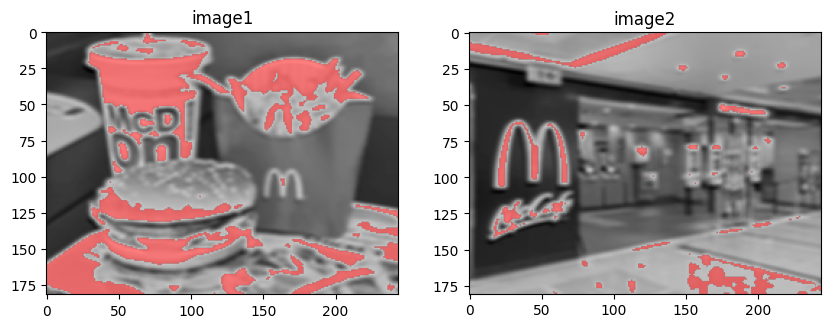

score : 
-243655268.0
clust1 from : 104577544.0 and clust2 from : 99415660.0 size of clust1 = 10800


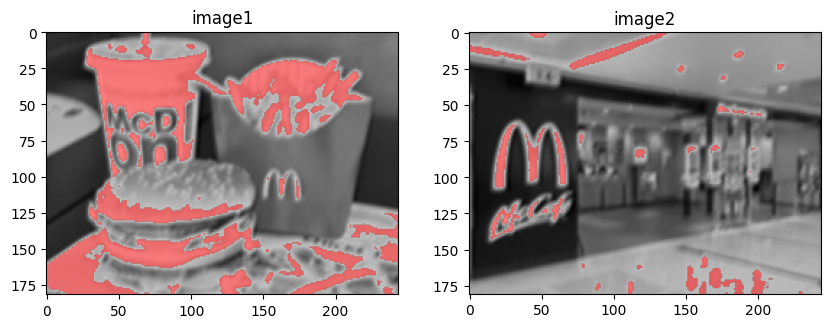

score : 
-243508252.8
clust1 from : 105498260.0 and clust2 from : 98674110.0 size of clust1 = 10821


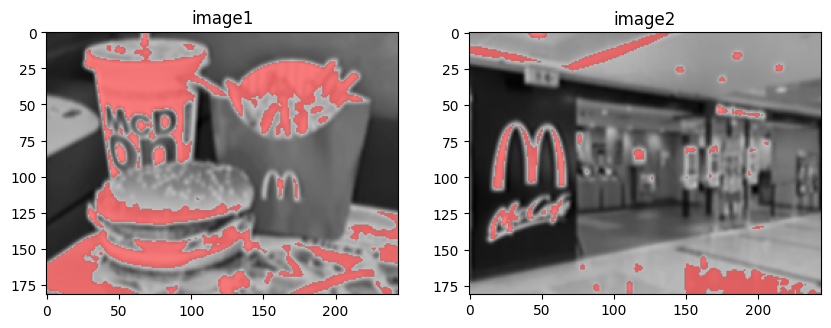

score : 
-239649323.2
clust1 from : 104334710.0 and clust2 from : 98278640.0 size of clust1 = 9026


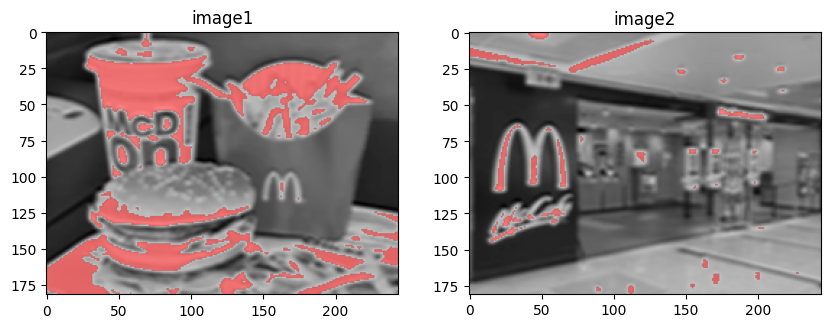

score : 
-213781712.8
clust1 from : 93075460.0 and clust2 from : 86714020.0 size of clust1 = 10373


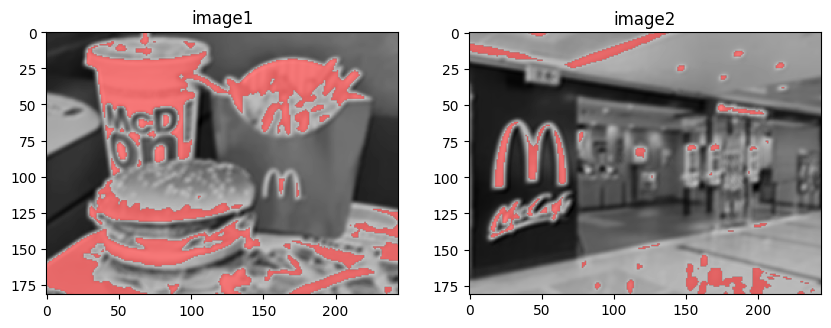

score : 
-211137268.0
clust1 from : 93053660.0 and clust2 from : 83593710.0 size of clust1 = 11007


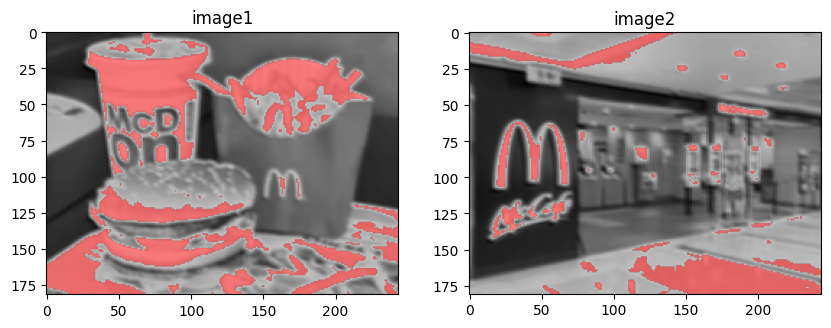

score : 
-208042907.2
clust1 from : 91335000.0 and clust2 from : 82496730.0 size of clust1 = 11046


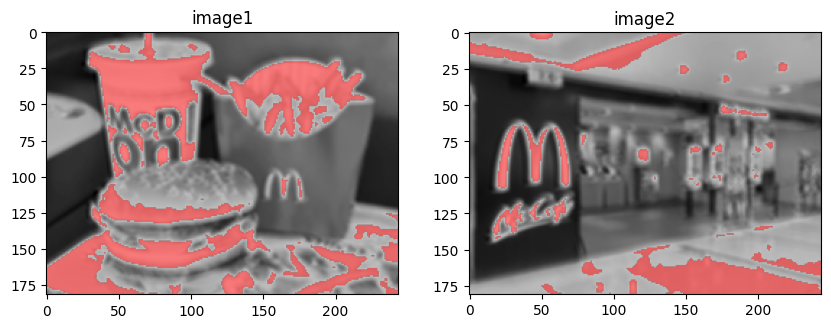

score : 
-206710174.4
clust1 from : 90181790.0 and clust2 from : 82960660.0 size of clust1 = 10836


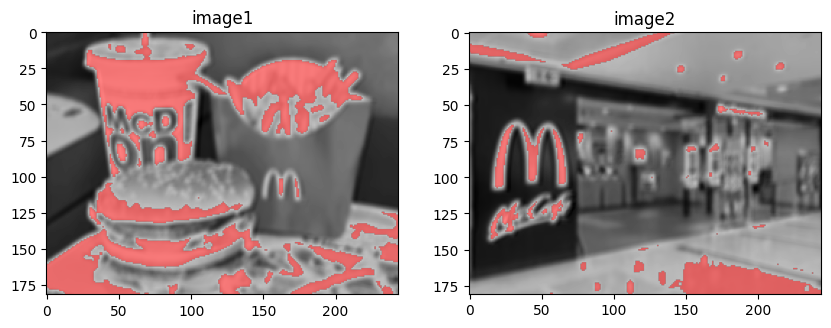

score : 
-205885574.4
clust1 from : 90535410.0 and clust2 from : 82385790.0 size of clust1 = 10424


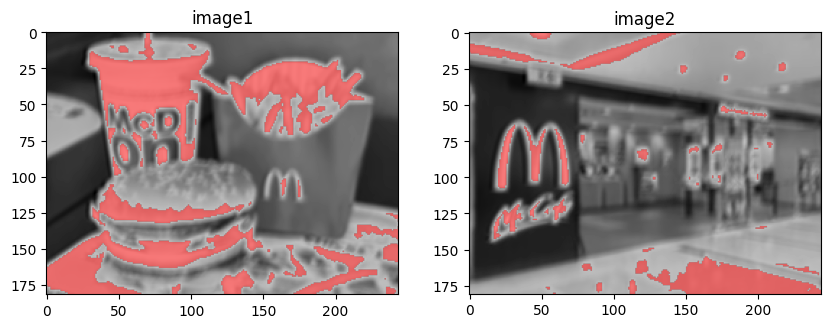

score : 
-204533436.8
clust1 from : 90366040.0 and clust2 from : 82618190.0 size of clust1 = 8435


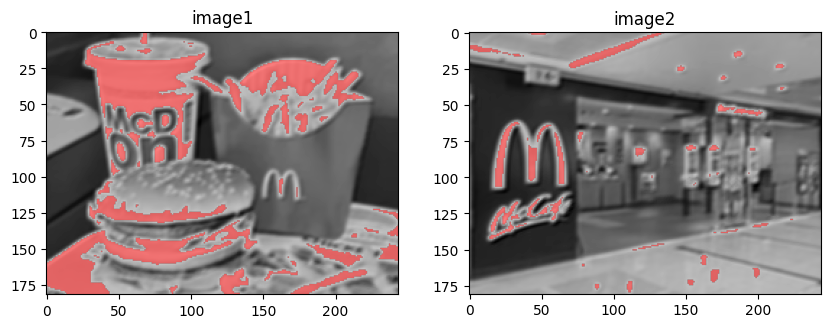

score : 
-201558288.0
clust1 from : 88024180.0 and clust2 from : 80378664.0 size of clust1 = 11101


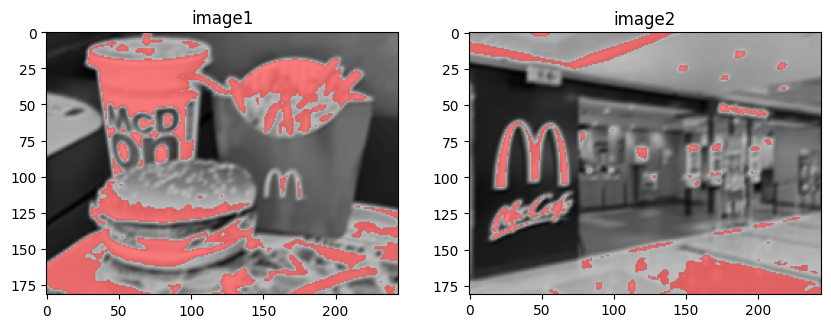

score : 
-199452137.6
clust1 from : 165322430.0 and clust2 from : 158617730.0 size of clust1 = 12925


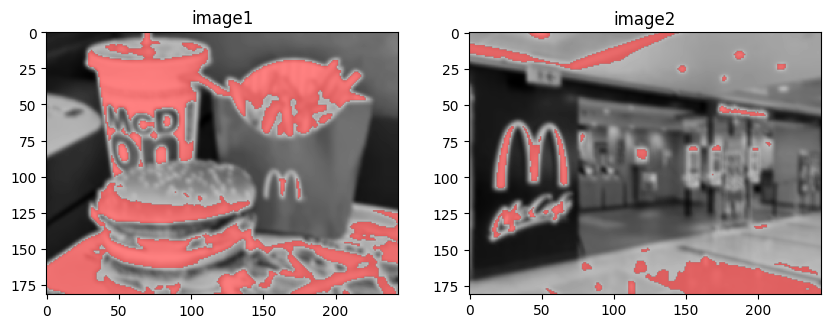

score : 
-198978705.60000002
clust1 from : 88958430.0 and clust2 from : 80619370.0 size of clust1 = 9170


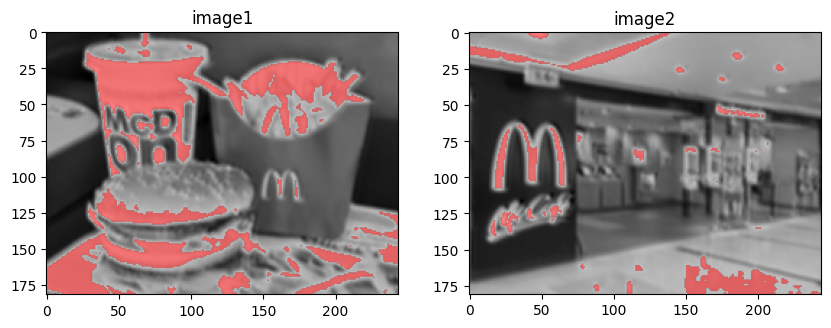

score : 
-195286225.6
clust1 from : 83475300.0 and clust2 from : 79689420.0 size of clust1 = 10623


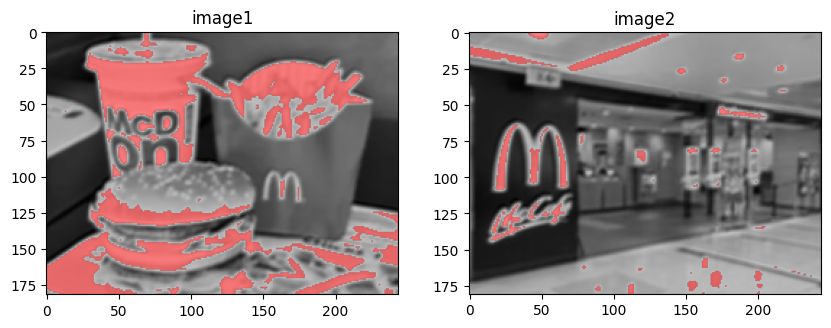

score : 
-194959686.4
clust1 from : 84882960.0 and clust2 from : 78206200.0 size of clust1 = 10738


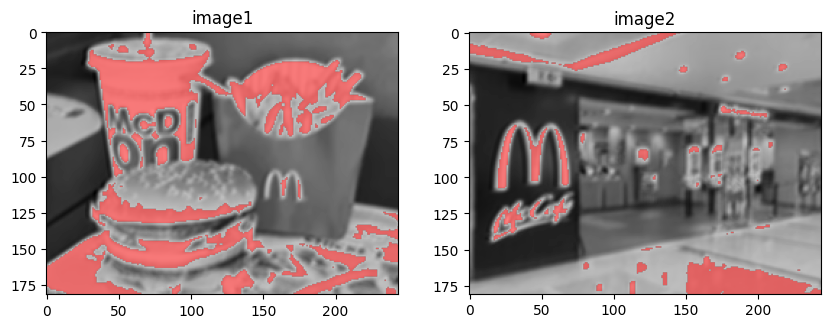

score : 
-191436827.2
clust1 from : 157138240.0 and clust2 from : 152728400.0 size of clust1 = 12917


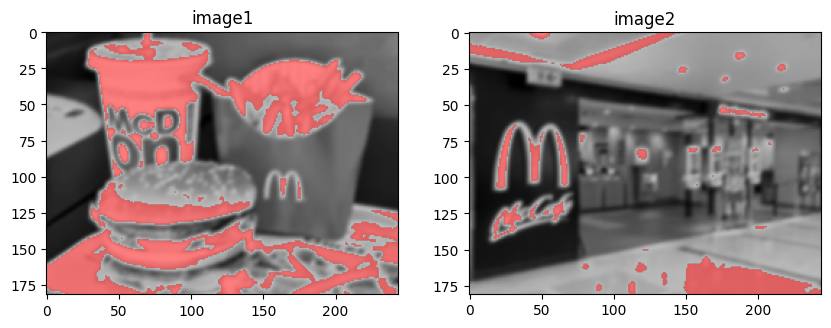

average of score = -213141849.75
max score= -900
min score= -251693808.0


In [92]:
import copy
image1 = processImage('image_test1.jpg')
image2 = processImage('image_test2.jpg')

Max_nbr_dimension = 4

filters = [None] * Max_nbr_dimension
feature_maps = [None] * Max_nbr_dimension
feature_maps[0] = create_image_for_tf(image1), create_image_for_tf(image2)
percentage_val = 0.008
nb_iter_max = 0
for i in range(1, Max_nbr_dimension):
    print("-----------------------------")
    if(i<2):
      nb_iter_max = 4000
    else:
      nb_iter_max = 2000
    filters[i], feature_map1, feature_map2 = extract_top_filters(feature_maps[i-1][0], feature_maps[i-1][1], nb_iter=nb_iter_max, dbscan_eps=0.1, percentage=percentage_val, dim=i)
    feature_maps[i] = (feature_map1, feature_map2)
    if(filters[i] is not None):
      print(f"number of {i}D filters extracted: {str(filters[i].shape[3])}")
      if(i<7):
        print(" max value of generated feature_map1 : "+str(tf.math.reduce_max(feature_map1)))
        print(" max value of generated feature_map2 : "+str(tf.math.reduce_max(feature_map2)))

print("-----------------------------")
# Handling the last case separately due to different function
_, _,_= extract_filters_visual(feature_maps[Max_nbr_dimension-2][0], feature_maps[Max_nbr_dimension-2][1], nb_iter=nb_iter_max, dbscan_eps=0.1, percentage=percentage_val,dim=Max_nbr_dimension)